## Fundamental extraction example

Use maelzel.snd.audiosample.Sample to load and manipulate an audio soundfile. A Sample can play itself (using csoundengine), has a nice html representation in jupyter with a waveform and browser playback.

In [1]:
from maelzel.snd import audiosample
import numpy as np
from emlib import numpytools

Sample(dur=20.0, sr=44100, ch=1)
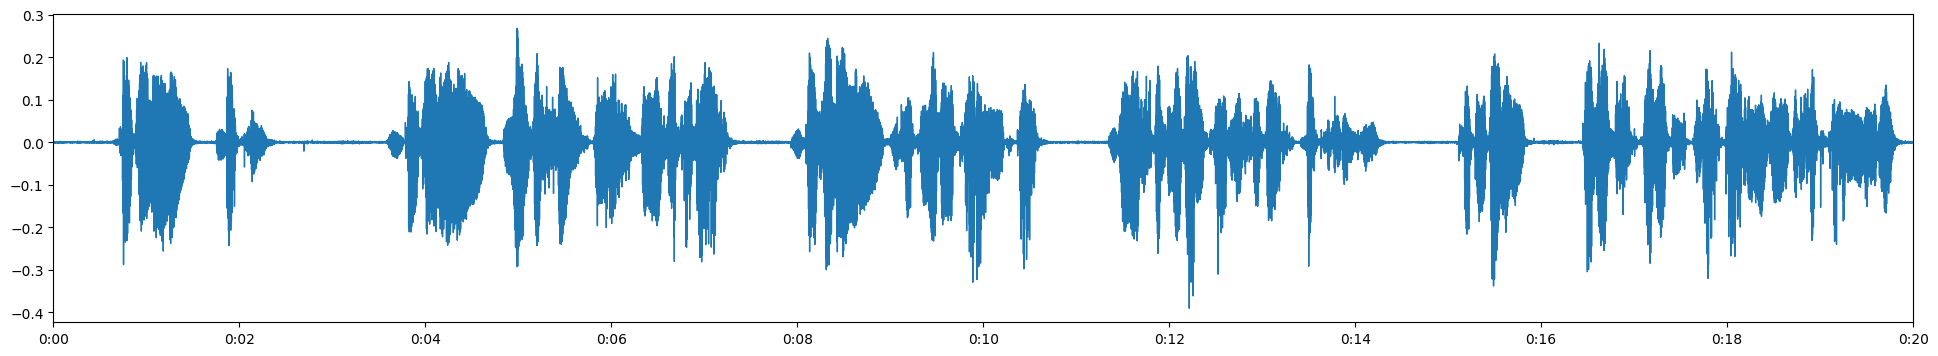

In [3]:
s = audiosample.Sample("snd/istambul2.flac")
s

### Extract the fundamental of and plot it against the spectrogram

mnOut size: 3446
m_pitchTrack size: 3446


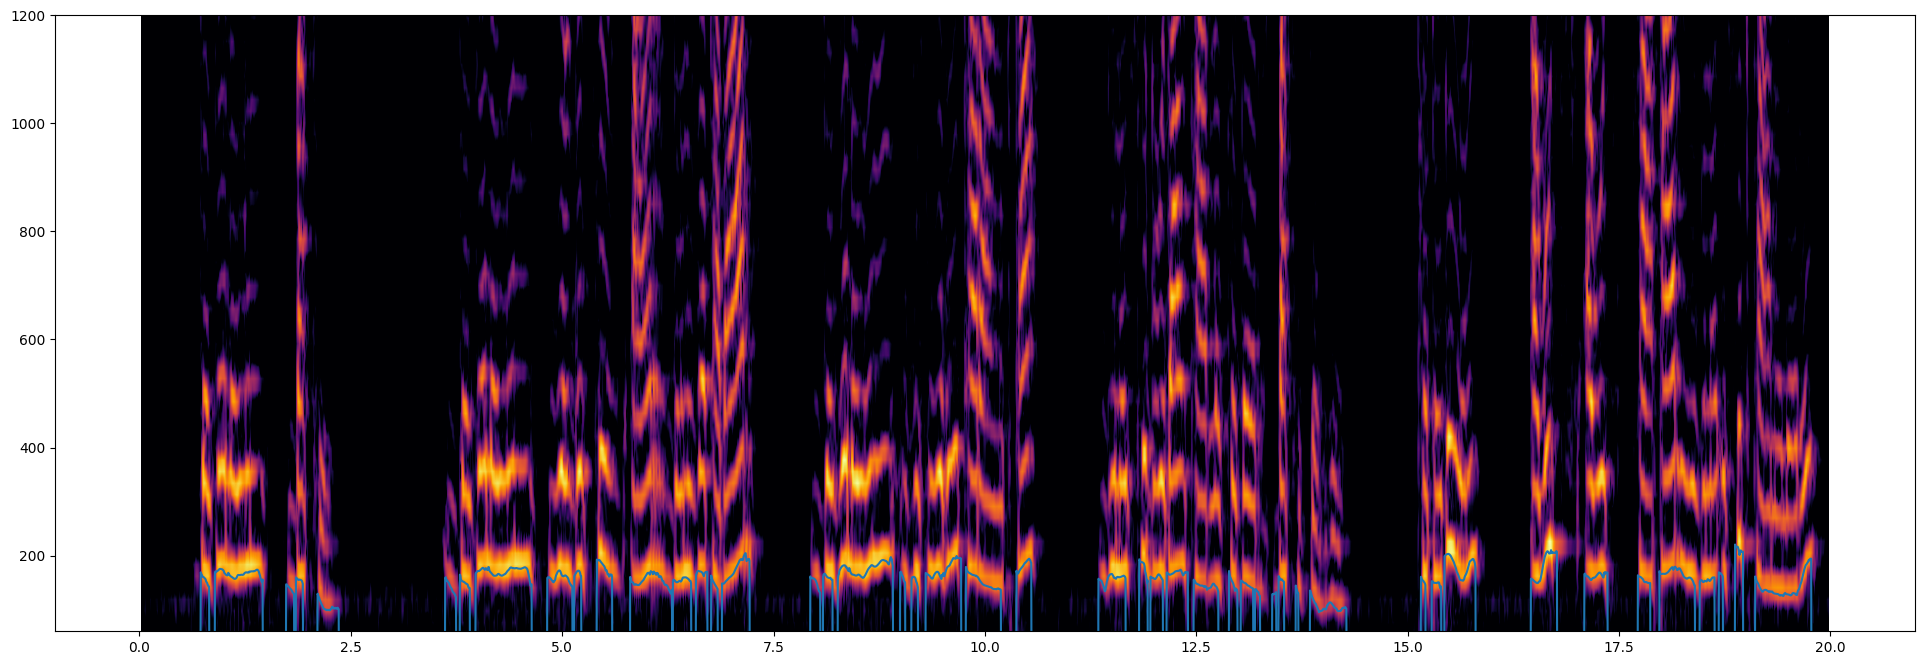

In [4]:
f0 = s.fundamentalBpf(fftsize=2048, overlap=8, method='pyin')
axes = s.plotSpectrogram(maxfreq=1200, minfreq=60, fftsize=2048, overlap=4, mindb=-80)
f0.plot(n=1000, axes=axes)

## Play the fundamental

Get the csound Engine used by `audiosample`, since sample playback needs to be choordinated with the fundamental playback

Create an instr to play back the extracted fundamental as a square wave

In [5]:
e = audiosample.()
session = e.session()
session.defInstr('vco', r'''
  |kfreq=200, kamp=0.1, igain=0.1, ichan=1|
  asig vco2 1, kfreq
  asig K35_lpf asig, 2000, 8
  asig *= a(lagud:k(kamp*igain, 0.05, 0.01))
  outch ichan, asig
''')

AttributeError: module 'maelzel.snd.audiosample' has no attribute 'getPlayEngine'

In [21]:
amp = f0 > 60
xs, freqs = f0.points()
freqpairs = numpytools.interlace(xs, freqs)
amppairs = numpytools.interlace(xs, amp.map(xs))

### Play sample and fundamental simultaneously

When scheduling multiple events which need to be in sync with each other,
it is recommended to encapsulate all in a `lockedElapsedTime` block. Within 
such a block, time is "frozen" so that events are scheduled in the future using
the same reference time. Without this, the time it takes to schedule events
might lead to events falling out of sync

In [25]:
with e.lockedElapsedTime():
    s.play(delay=256/e.sr, pan=0)
    f0synth = session.sched('vco', dur=s.duration+0.1, kamp=0, ichan=2)
    f0synth.automatep('kfreq', freqpairs)
    f0synth.automatep('kamp', amppairs)

### Render to a soundfile

When rendering offline, no encapsulation is needed. Besides that, the code is exactly the same for live and offline rendering

In [26]:
# Make an offline renderer based on the instrument definitions of the current session. 
r = session.makeRenderer(sr=e.sr, nchnls=2)

r.playSample(s.getChannel(0).samples, sr=s.sr, delay=256/r.sr, chan=1) 
f0synth = r.sched('vco', dur=s.duration+0.1, kamp=0, ichan=2)
f0synth.automatep('kfreq', freqpairs)
f0synth.automatep('kamp', amppairs)

r.render("fundamental.wav", quiet=True)

'fundamental.wav'

Sample: dur=20.100000 sr=48000 ch=2
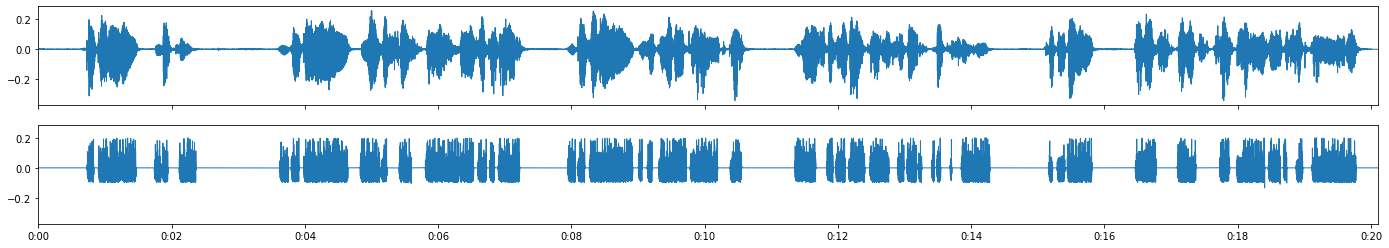

In [28]:
# display the generated file
audiosample.Sample("fundamental.wav")